#Importing packages and Loading datasets

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from torchvision import datasets
from tqdm.notebook import tqdm

sns.set_theme()
mnist_train = datasets.FashionMNIST('../data', train=True, download=True)
mnist_test = datasets.FashionMNIST('../data', train=False, download=True)

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting ../data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ../data/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting ../data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ../data/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting ../data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ../data/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting ../data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/FashionMNIST/raw



# A) Showing images

In [ ]:
def show_images(imgs):
  random_indices = np.random.randint(0, len(imgs), size=4)
  fig, ax = plt.subplots(2, 2, figsize=(10, 10))
  for i in range(4):
    ax[i//2, i%2].imshow(imgs[random_indices[i]][0], cmap='gray')
    ax[i//2, i%2].grid(False)

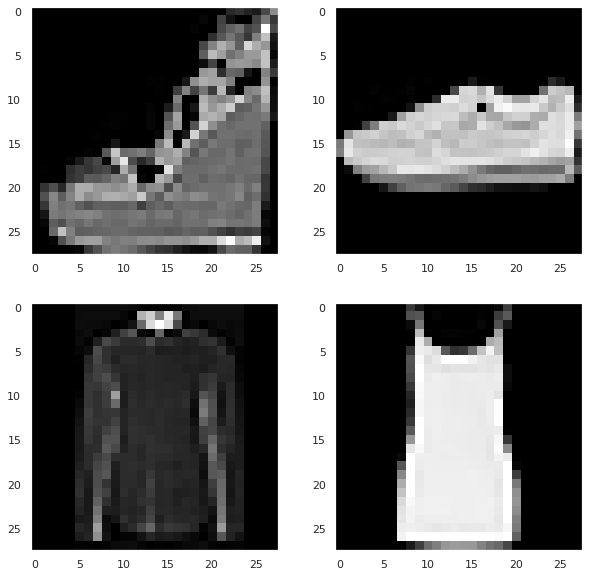

In [ ]:
show_images(mnist_train)

# B) MLP

In [ ]:
def sigmoid(x, derivative=False):
    if derivative:
        return np.exp(-x)/(1+np.exp(-x))**2
    return 1/(1+np.exp(-x))

def relu(x, derivative=False):
    if derivative:
        return x > 0
    return np.maximum(x, 0.0)

def softmax(x, derivative=False):
    exps = np.exp(x - x.max())
    if derivative:
        return exps / np.sum(exps, axis=0) * (1 - exps / np.sum(exps, axis=0))
    return exps / np.sum(exps, axis=0)

class NeuralNetwork():
    def __init__(self, sizes, optimizer= None, epochs=10, lr=0.003, beta=0.9):
        self.sizes = sizes
        self.optimizer=optimizer
        self.opt_params = {}
        self.nolayers = len(self.sizes)-1
        self.epochs = epochs
        self.lr = lr
        self.beta = beta
        self.derivatives = {}
        self.params = self.initialization()   

    def initialization(self):
        params = {}
        for l in range(1, self.nolayers+1):
            params[f'W{l}'] = np.random.standard_normal((self.sizes[l], self.sizes[l-1]))
            params[f'b{l}'] = np.zeros((self.sizes[l], 1))
        if self.optimizer == 'momentum':
            for param in params:
                self.opt_params[f'v_{param}'] = np.zeros_like(params[param])
        return params

    def forward_pass(self, x_train, activation='sigmoid'):
        params = self.params
        nolayers = self.nolayers
        params['A0'] = x_train 
        for l in range(1, nolayers+1):
            params[f'Z{l}'] = params[f'W{l}'] @ params[f'A{l-1}'] + params[f'b{l}']
            if l == nolayers:
                params[f'A{l}'] = softmax(params[f'Z{l}'])
            else:
                if activation == 'sigmoid':
                    params[f'A{l}'] = sigmoid(params[f'Z{l}'])   
                elif activation == 'relu':
                    params[f'A{l}'] = relu(params[f'Z{l}']) 
        
        return params[f'A{nolayers}']   

    def backward_pass(self, y_train, activation='sigmoid'):
        params = self.params
        derivatives = self.derivatives
        nolayers = self.nolayers
        derivatives[f'Z{nolayers}'] = params[f'A{nolayers}'] - y_train
        derivatives[f'W{nolayers}'] = derivatives[f'Z{nolayers}'] @ params[f'A{nolayers-1}'].T
        derivatives[f'b{nolayers}'] = derivatives[f'Z{nolayers}']
        for l in range(nolayers-1, 0, -1):
            if activation == 'sigmoid':
                derivatives[f'Z{l}'] = (params[f'W{l+1}'].T @ derivatives[f'Z{l+1}']) * sigmoid(params[f'Z{l}'], derivative=True)
            elif activation == 'relu':
                derivatives[f'Z{l}'] = (params[f'W{l+1}'].T @ derivatives[f'Z{l+1}']) * relu(params[f'Z{l}'], derivative=True)
            derivatives[f'W{l}'] = derivatives[f'Z{l}'] @ params[f'A{l-1}'].T
            derivatives[f'b{l}'] = derivatives[f'Z{l}']
        
    def update_params(self, optimizer=None):
        params = self.params
        derivatives = self.derivatives
        if optimizer == 'momentum':
            opt_params = self.opt_params
            for l in range(1, self.nolayers+1):
                opt_params[f'v_W{l}'] = self.beta * opt_params[f'v_W{l}'] + self.lr * derivatives[f'W{l}']
                opt_params[f'v_b{l}'] = self.beta * opt_params[f'v_b{l}'] + self.lr * derivatives[f'b{l}']
                params[f'W{l}'] -= opt_params[f'v_W{l}']
                params[f'b{l}'] -= opt_params[f'v_b{l}']
        else:
            for l in range(1, self.nolayers+1):
                params[f'W{l}'] -= self.lr * derivatives[f'W{l}']
                params[f'b{l}'] -= self.lr * derivatives[f'b{l}']

    def compute_cost(self, y):
        params = self.params
        return ((params[f'A{self.nolayers}'] - y)**2).sum()
        
    def train(self, train, test, activation='sigmoid', quiet=False):
        train_costs, test_costs = [], []
        for epoch in range(self.epochs):
            train_cost = 0
            train_true_preds = 0  
            test_cost = 0
            test_true_preds = 0
            for idx in tqdm(range(len(train))):
                x_train = np.asarray(train[idx][0], dtype=np.float32)
                x_train = (x_train.reshape((-1, 1))/255)
                y_train = np.zeros((10, 1), dtype=np.float32)
                y_train[train[idx][1]] = 1
                if activation == 'sigmoid':
                    y_pred = self.forward_pass(x_train)
                elif activation == 'relu':
                    y_pred = self.forward_pass(x_train, activation='relu')
                train_cost += self.compute_cost(y_train)
                if y_pred.argmax() == y_train.argmax():
                    train_true_preds += 1
                if activation == 'sigmoid':
                    self.backward_pass(y_train)
                elif activation == 'relu':
                    self.backward_pass(y_train, activation='relu')
                self.update_params(optimizer=self.optimizer)
            train_cost = train_cost/len(train)
            train_acc = train_true_preds/len(train)*100
            train_costs.append(train_cost)
            for idx in range(len(test)):
                x_test = np.asarray(test[idx][0], dtype=np.float32)
                x_test = (x_test.reshape((-1, 1))/255)
                y_test = np.zeros((10, 1), dtype=np.float32)
                y_test[test[idx][1]] = 1
                if activation == 'sigmoid':
                    y_pred = self.forward_pass(x_test)
                elif activation == 'relu':
                    y_pred = self.forward_pass(x_test, activation='relu')
                test_cost += self.compute_cost(y_test)
                if y_pred.argmax() == y_test.argmax():
                    test_true_preds += 1
            test_cost = test_cost/len(test)
            test_acc = test_true_preds/len(test)*100
            test_costs.append(test_cost)
            print(f'epoch: {epoch+1} | train cost: {train_cost:.4} | train accuracy: {train_acc:.4} | test cost: {test_cost:.4} | test accuracy: {test_acc:.4}')
            print("-"*100)
        if not quiet:
            plt.figure(figsize=(10, 7))
            plt.plot(np.arange(1, self.epochs+1), train_costs, label='Train cost')
            plt.plot(np.arange(1, self.epochs+1), test_costs, label='Test cost')
            plt.legend()     
    

  0%|          | 0/60000 [00:00<?, ?it/s]

epoch: 1 | train cost: 0.4152 | train accuracy: 69.72 | test cost: 0.3431 | test accuracy: 74.8
----------------------------------------------------------------------------------------------------


  0%|          | 0/60000 [00:00<?, ?it/s]

epoch: 2 | train cost: 0.3118 | train accuracy: 77.45 | test cost: 0.3116 | test accuracy: 77.04
----------------------------------------------------------------------------------------------------


  0%|          | 0/60000 [00:00<?, ?it/s]

epoch: 3 | train cost: 0.2854 | train accuracy: 79.51 | test cost: 0.2954 | test accuracy: 78.69
----------------------------------------------------------------------------------------------------


  0%|          | 0/60000 [00:00<?, ?it/s]

epoch: 4 | train cost: 0.2692 | train accuracy: 80.77 | test cost: 0.2844 | test accuracy: 79.69
----------------------------------------------------------------------------------------------------


  0%|          | 0/60000 [00:00<?, ?it/s]

epoch: 5 | train cost: 0.2574 | train accuracy: 81.69 | test cost: 0.2759 | test accuracy: 80.32
----------------------------------------------------------------------------------------------------


  0%|          | 0/60000 [00:00<?, ?it/s]

epoch: 6 | train cost: 0.2482 | train accuracy: 82.44 | test cost: 0.269 | test accuracy: 80.96
----------------------------------------------------------------------------------------------------


  0%|          | 0/60000 [00:00<?, ?it/s]

epoch: 7 | train cost: 0.2407 | train accuracy: 82.94 | test cost: 0.2634 | test accuracy: 81.41
----------------------------------------------------------------------------------------------------


  0%|          | 0/60000 [00:00<?, ?it/s]

epoch: 8 | train cost: 0.2343 | train accuracy: 83.36 | test cost: 0.2587 | test accuracy: 81.75
----------------------------------------------------------------------------------------------------


  0%|          | 0/60000 [00:00<?, ?it/s]

epoch: 9 | train cost: 0.2287 | train accuracy: 83.79 | test cost: 0.2547 | test accuracy: 81.97
----------------------------------------------------------------------------------------------------


  0%|          | 0/60000 [00:00<?, ?it/s]

epoch: 10 | train cost: 0.2237 | train accuracy: 84.15 | test cost: 0.2512 | test accuracy: 82.2
----------------------------------------------------------------------------------------------------


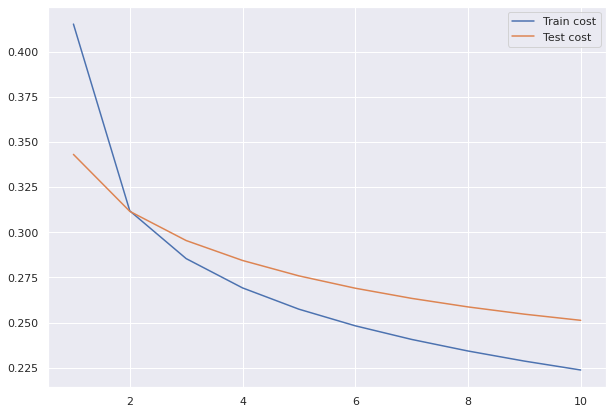

In [ ]:
nn = NeuralNetwork(sizes=[784, 128, 64, 10], epochs=10)
nn.train(mnist_train, mnist_test)

# ReLU

  0%|          | 0/60000 [00:00<?, ?it/s]

epoch: 1 | train cost: 0.7236 | train accuracy: 32.06 | test cost: 0.6741 | test accuracy: 35.9
----------------------------------------------------------------------------------------------------


  0%|          | 0/60000 [00:00<?, ?it/s]

epoch: 2 | train cost: 0.6791 | train accuracy: 36.26 | test cost: 0.6688 | test accuracy: 38.65
----------------------------------------------------------------------------------------------------


  0%|          | 0/60000 [00:00<?, ?it/s]

epoch: 3 | train cost: 0.6585 | train accuracy: 40.05 | test cost: 0.6367 | test accuracy: 41.84
----------------------------------------------------------------------------------------------------


  0%|          | 0/60000 [00:00<?, ?it/s]

epoch: 4 | train cost: 0.595 | train accuracy: 46.83 | test cost: 0.5987 | test accuracy: 46.73
----------------------------------------------------------------------------------------------------


  0%|          | 0/60000 [00:00<?, ?it/s]

epoch: 5 | train cost: 0.5465 | train accuracy: 50.68 | test cost: 0.5142 | test accuracy: 54.21
----------------------------------------------------------------------------------------------------


  0%|          | 0/60000 [00:00<?, ?it/s]

epoch: 6 | train cost: 0.5304 | train accuracy: 52.74 | test cost: 0.518 | test accuracy: 54.56
----------------------------------------------------------------------------------------------------


  0%|          | 0/60000 [00:00<?, ?it/s]

epoch: 7 | train cost: 0.5252 | train accuracy: 53.65 | test cost: 0.4856 | test accuracy: 56.88
----------------------------------------------------------------------------------------------------


  0%|          | 0/60000 [00:00<?, ?it/s]

epoch: 8 | train cost: 0.5054 | train accuracy: 55.3 | test cost: 0.4785 | test accuracy: 58.76
----------------------------------------------------------------------------------------------------


  0%|          | 0/60000 [00:00<?, ?it/s]

epoch: 9 | train cost: 0.4931 | train accuracy: 56.34 | test cost: 0.4845 | test accuracy: 57.14
----------------------------------------------------------------------------------------------------


  0%|          | 0/60000 [00:00<?, ?it/s]

epoch: 10 | train cost: 0.471 | train accuracy: 58.74 | test cost: 0.4835 | test accuracy: 57.06
----------------------------------------------------------------------------------------------------


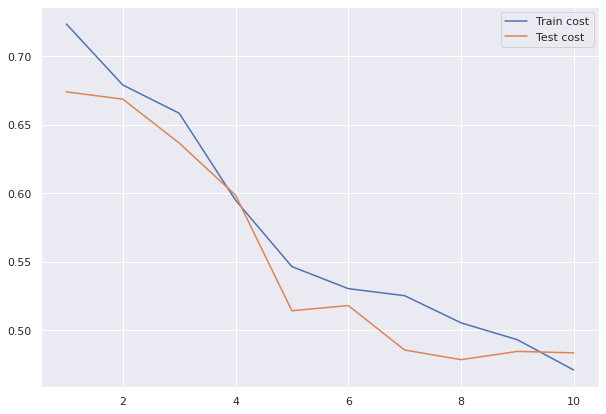

In [ ]:
nn_relu = NeuralNetwork(sizes=[784, 128, 64, 10], epochs=10)
nn_relu.train(mnist_train, mnist_test, activation='relu')

# Momentum

  0%|          | 0/60000 [00:00<?, ?it/s]

epoch: 1 | train cost: 0.3341 | train accuracy: 76.2 | test cost: 0.2765 | test accuracy: 80.39
----------------------------------------------------------------------------------------------------


  0%|          | 0/60000 [00:00<?, ?it/s]

epoch: 2 | train cost: 0.2588 | train accuracy: 81.81 | test cost: 0.2617 | test accuracy: 81.32
----------------------------------------------------------------------------------------------------


  0%|          | 0/60000 [00:00<?, ?it/s]

epoch: 3 | train cost: 0.2352 | train accuracy: 83.55 | test cost: 0.2385 | test accuracy: 83.4
----------------------------------------------------------------------------------------------------


  0%|          | 0/60000 [00:00<?, ?it/s]

epoch: 4 | train cost: 0.2204 | train accuracy: 84.55 | test cost: 0.2346 | test accuracy: 83.61
----------------------------------------------------------------------------------------------------


  0%|          | 0/60000 [00:00<?, ?it/s]

epoch: 5 | train cost: 0.2085 | train accuracy: 85.48 | test cost: 0.231 | test accuracy: 83.78
----------------------------------------------------------------------------------------------------


  0%|          | 0/60000 [00:00<?, ?it/s]

epoch: 6 | train cost: 0.1999 | train accuracy: 86.06 | test cost: 0.2242 | test accuracy: 84.43
----------------------------------------------------------------------------------------------------


  0%|          | 0/60000 [00:00<?, ?it/s]

epoch: 7 | train cost: 0.1923 | train accuracy: 86.54 | test cost: 0.2216 | test accuracy: 84.25
----------------------------------------------------------------------------------------------------


  0%|          | 0/60000 [00:00<?, ?it/s]

epoch: 8 | train cost: 0.1857 | train accuracy: 87.11 | test cost: 0.2213 | test accuracy: 84.81
----------------------------------------------------------------------------------------------------


  0%|          | 0/60000 [00:00<?, ?it/s]

epoch: 9 | train cost: 0.1784 | train accuracy: 87.63 | test cost: 0.224 | test accuracy: 84.23
----------------------------------------------------------------------------------------------------


  0%|          | 0/60000 [00:00<?, ?it/s]

epoch: 10 | train cost: 0.1734 | train accuracy: 87.89 | test cost: 0.2144 | test accuracy: 85.09
----------------------------------------------------------------------------------------------------


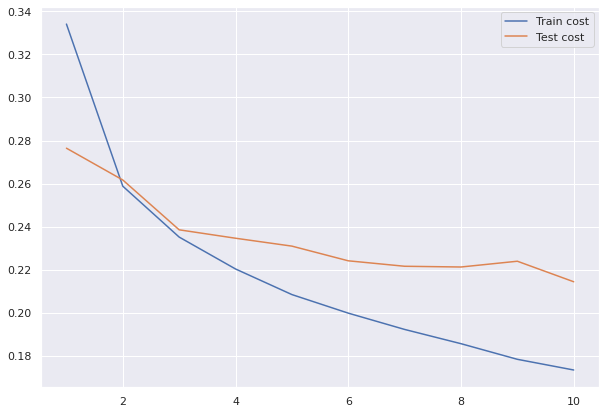

In [ ]:
nn_momentum = NeuralNetwork(sizes=[784, 128, 64, 10], optimizer='momentum', epochs=10)
nn_momentum.train(mnist_train, mnist_test)

# Three hidden layers

  0%|          | 0/60000 [00:00<?, ?it/s]

epoch: 1 | train cost: 0.4194 | train accuracy: 68.79 | test cost: 0.3401 | test accuracy: 75.28
----------------------------------------------------------------------------------------------------


  0%|          | 0/60000 [00:00<?, ?it/s]

epoch: 2 | train cost: 0.3098 | train accuracy: 77.62 | test cost: 0.305 | test accuracy: 78.17
----------------------------------------------------------------------------------------------------


  0%|          | 0/60000 [00:00<?, ?it/s]

epoch: 3 | train cost: 0.2812 | train accuracy: 79.89 | test cost: 0.2888 | test accuracy: 79.51
----------------------------------------------------------------------------------------------------


  0%|          | 0/60000 [00:00<?, ?it/s]

epoch: 4 | train cost: 0.2642 | train accuracy: 81.12 | test cost: 0.2781 | test accuracy: 80.31
----------------------------------------------------------------------------------------------------


  0%|          | 0/60000 [00:00<?, ?it/s]

epoch: 5 | train cost: 0.2524 | train accuracy: 82.02 | test cost: 0.2699 | test accuracy: 80.98
----------------------------------------------------------------------------------------------------


  0%|          | 0/60000 [00:00<?, ?it/s]

epoch: 6 | train cost: 0.2432 | train accuracy: 82.7 | test cost: 0.2636 | test accuracy: 81.5
----------------------------------------------------------------------------------------------------


  0%|          | 0/60000 [00:00<?, ?it/s]

epoch: 7 | train cost: 0.2358 | train accuracy: 83.25 | test cost: 0.2586 | test accuracy: 81.82
----------------------------------------------------------------------------------------------------


  0%|          | 0/60000 [00:00<?, ?it/s]

epoch: 8 | train cost: 0.2294 | train accuracy: 83.71 | test cost: 0.2545 | test accuracy: 81.93
----------------------------------------------------------------------------------------------------


  0%|          | 0/60000 [00:00<?, ?it/s]

epoch: 9 | train cost: 0.2238 | train accuracy: 84.08 | test cost: 0.251 | test accuracy: 82.2
----------------------------------------------------------------------------------------------------


  0%|          | 0/60000 [00:00<?, ?it/s]

epoch: 10 | train cost: 0.2187 | train accuracy: 84.47 | test cost: 0.2481 | test accuracy: 82.44
----------------------------------------------------------------------------------------------------


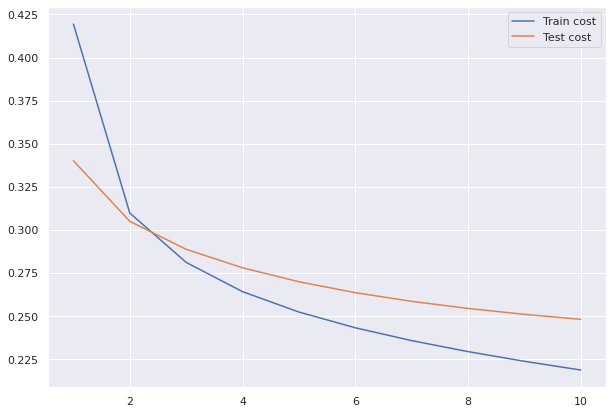

In [ ]:
nn_three_hidden = NeuralNetwork(sizes=[784, 128, 64, 64, 10], epochs=10)
nn_three_hidden.train(mnist_train, mnist_test)

# Pytorch

  0%|          | 0/60000 [00:00<?, ?it/s]

epoch: 1 | train cost: 0.697756 | train accuracy: 57.332 | test cost: 0.678603 | test accuracy: 76.71
--------------------------------------------------------------------------------------------------------------


  0%|          | 0/60000 [00:00<?, ?it/s]

epoch: 2 | train cost: 0.675309 | train accuracy: 80.235 | test cost: 0.673561 | test accuracy: 81.81
--------------------------------------------------------------------------------------------------------------


  0%|          | 0/60000 [00:00<?, ?it/s]

epoch: 3 | train cost: 0.67228 | train accuracy: 82.988 | test cost: 0.672778 | test accuracy: 82.43
--------------------------------------------------------------------------------------------------------------


  0%|          | 0/60000 [00:00<?, ?it/s]

epoch: 4 | train cost: 0.671083 | train accuracy: 84.115 | test cost: 0.672033 | test accuracy: 83.23
--------------------------------------------------------------------------------------------------------------


  0%|          | 0/60000 [00:00<?, ?it/s]

epoch: 5 | train cost: 0.670215 | train accuracy: 85.0 | test cost: 0.671355 | test accuracy: 83.68
--------------------------------------------------------------------------------------------------------------


  0%|          | 0/60000 [00:00<?, ?it/s]

epoch: 6 | train cost: 0.669636 | train accuracy: 85.508 | test cost: 0.671309 | test accuracy: 83.61
--------------------------------------------------------------------------------------------------------------


  0%|          | 0/60000 [00:00<?, ?it/s]

epoch: 7 | train cost: 0.669181 | train accuracy: 85.997 | test cost: 0.671596 | test accuracy: 83.36
--------------------------------------------------------------------------------------------------------------


  0%|          | 0/60000 [00:00<?, ?it/s]

epoch: 8 | train cost: 0.668667 | train accuracy: 86.53 | test cost: 0.670193 | test accuracy: 84.74
--------------------------------------------------------------------------------------------------------------


  0%|          | 0/60000 [00:00<?, ?it/s]

epoch: 9 | train cost: 0.668406 | train accuracy: 86.752 | test cost: 0.67055 | test accuracy: 84.55
--------------------------------------------------------------------------------------------------------------


  0%|          | 0/60000 [00:00<?, ?it/s]

epoch: 10 | train cost: 0.668012 | train accuracy: 87.138 | test cost: 0.670124 | test accuracy: 84.98
--------------------------------------------------------------------------------------------------------------


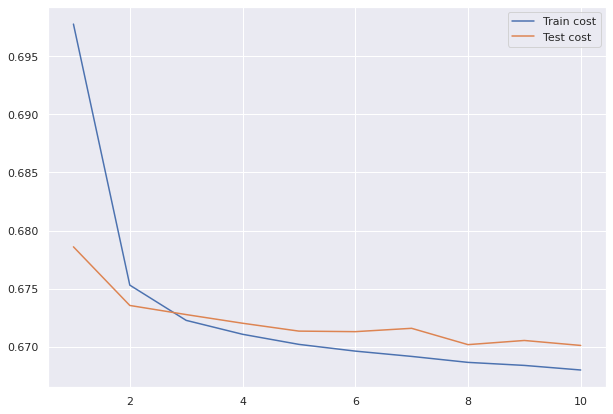

In [ ]:
import torch
from torch import nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import transforms
from torch.utils import data
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

def one_hot_encode(y):
    encoded = torch.zeros([10])
    encoded[y[0]] = 1
    return encoded

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(784, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 10)
    
    def forward_pass(self, x):
        x = torch.sigmoid(self.fc1(x))
        x = torch.sigmoid(self.fc2(x))
        x = torch.softmax(self.fc3(x), dim=0)
        return x      

trans = transforms.ToTensor()
mnist_train = torchvision.datasets.FashionMNIST(root='../data', train=True, transform=trans, download=True)
mnist_test = torchvision.datasets.FashionMNIST(root='../data', train=False, transform=trans, download=True)
train_iter = data.DataLoader(mnist_train, batch_size=1)
test_iter = data.DataLoader(mnist_test, batch_size=1)

model = Net()
optimizer = torch.optim.SGD(model.parameters(), lr=0.3)
loss = nn.BCEWithLogitsLoss()
n_epochs = 10
train_costs, test_costs = [], []
for epoch in range(n_epochs):
    train_cost, test_cost = 0, 0
    train_acc, test_acc = 0, 0
    model.train()
    for X, y in tqdm(train_iter):
        c = y[0]
        y = one_hot_encode(y)
        optimizer.zero_grad()
        output = model.forward_pass(torch.flatten(X))
        train_acc += 1 if output.argmax() == c else 0
        l = loss(output, y)
        l.backward()
        optimizer.step()
        train_cost += l.item()
    train_acc /= len(train_iter)
    train_cost /= len(train_iter)
    train_costs.append(train_cost)
    model.eval()
    for X, y in test_iter:
        c = y[0]
        y = one_hot_encode(y)
        output = model.forward_pass(torch.flatten(X))
        test_acc += 1 if output.argmax() == c else 0
        l = loss(output, y)
        test_cost += l.item()
    test_acc /= len(test_iter)
    test_cost /= len(test_iter)
    test_costs.append(test_cost)
    print(f'epoch: {epoch+1} | train cost: {train_cost:.6} | train accuracy: {train_acc*100:.5} | test cost: {test_cost:.6} | test accuracy: {test_acc*100:.5}')
    print("-"*110)
plt.figure(figsize=(10, 7))
plt.plot(torch.arange(1, n_epochs+1), train_costs, label='Train cost')
plt.plot(torch.arange(1, n_epochs+1), test_costs, label='Test cost')
plt.legend()

# References
- https://mlfromscratch.com/neural-network-tutorial/#/
- https://medium.com/binaryandmore/beginners-guide-to-deriving-and-implementing-backpropagation-e3c1a5a1e536
- https://towardsdatascience.com/derivative-of-the-softmax-function-and-the-categorical-cross-entropy-loss-ffceefc081d1
- https://towardsdatascience.com/stochastic-gradient-descent-with-momentum-a84097641a5d
